In [1]:
!pip install tensorflow_ranking

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

import pickle

2023-01-16 16:17:31.352192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 16:17:32.417686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-16 16:17:32.417776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-16 16:17:32.417786: W tensorfl

In [3]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [4]:
file_name = "windowed_raw" # or offsets_2

x_data = np.load(f"data/processed/x_windowed_filtered.npy") # pre-filtered data
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

print(x_data.shape)
#times_to_add = 8

#x_data = np.concatenate([x_data] + [x_data + np.random.normal(0,0.1,x_data.shape) for i in range(times_to_add)])
#y_intent = np.concatenate([y_intent] + [y_intent for i in range(times_to_add)])

(34371, 200, 19)


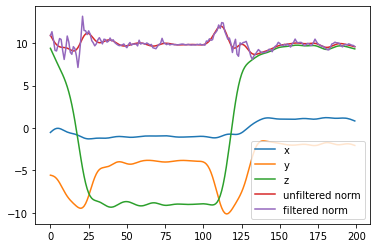

In [5]:
plt.plot(x_data[0,:,0], label='x')
plt.plot(x_data[0,:,1], label='y')
plt.plot(x_data[0,:,2], label='z')
plt.plot(x_data[0,:,16], label='unfiltered norm')
plt.plot(x_data[0,:,3], label='filtered norm')
plt.legend()

In [6]:
import csv, math, os, re, statistics, sys
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew, iqr

a=1/0

def feature_min(g_data):
    return np.amin(g_data, axis=0)

def feature_max(g_data):	
    return np.amax(g_data, axis=0)

def feature_mean(g_data):
	return np.mean(g_data, axis=0)

def feature_med(g_data):
	return np.median(g_data, axis=0)
	
def feature_stdev(g_data):
	return np.std(g_data, axis=0)

def feature_var(g_data):
	return np.var(g_data, axis=0)

def feature_iqr(g_data):
    return iqr(g_data, axis=0)

def feature_kurt(g_data):
	return kurtosis(g_data, axis=0)

def feature_skew(g_data):
	return skew(g_data, axis=0)

def feature_pkcount(g_data, threshold):
    channels = g_data.shape[1]
    peaks = []
    for i in range(channels):
        datum = g_data[:, i]
        peaks.append(len(find_peaks(datum, prominence = threshold)[0]))
    return np.array(peaks)

def feature_velo_disp(g_data):
    f = []
    indices= [[0,1,2], [4,5,6], [12,13,14]]
    n = g_data.shape[1] - 1
    
    for a,b,c in indices:
        vx = [0]
        dx = [0]
        vy = [0]
        dy = [0]
        vz = [0]
        dz = [0]
        d = [0]
        dt = float(4.0 / n) #sample interval - based on a time slice of 4 seconds
        for j in range(n):
            vx.append(vx[j] + (g_data[j][a] + g_data[j + 1][a]) / 2 * dt / 10)
            dx.append(dx[j] + vx[j + 1] * dt / 10)
            vy.append(vy[j] + (g_data[j][b] + g_data[j + 1][b]) / 2 * dt / 10)
            dy.append(dy[j] + vy[j + 1] * dt / 10)
            vz.append(vz[j] + (g_data[j][c] + g_data[j + 1][c]) / 2 * dt / 10)
            dz.append(dz[j] + vz[j + 1] * dt / 10)
            d.append(math.sqrt(dx[j+1] **2 + dy[j+1] **2 + dz[j+1] **2 ))
        vx.pop(0)
        vy.pop(0)
        vz.pop(0)

        if False:
            f_names.append(sensor + '-x-velomean')
            f_names.append(sensor + '-y-velomean')
            f_names.append(sensor + '-z-velomean')
            f_names.append(sensor + '-x-velomax')
            f_names.append(sensor + '-y-velomax')
            f_names.append(sensor + '-z-velomax')
            f_names.append(sensor + '-x-disp')
            f_names.append(sensor + '-y-disp')
            f_names.append(sensor + '-z-disp')
            f_names.append(sensor + '-disptotal')

        f.append(sum(vx) / len(vx))
        f.append(sum(vy) / len(vy))
        f.append(sum(vz) / len(vz))
        f.append(max(vx, key = abs))
        f.append(max(vy, key = abs))
        f.append(max(vz, key = abs))
        f.append(dx[len(dx) - 1])
        f.append(dy[len(dy) - 1])
        f.append(dz[len(dz) - 1])
        f.append(d[len(d) - 1])
    return np.array(f)

def extract_features(g_data):   
	f_data = []
	f_data.append(feature_min(g_data))
	f_data.append(feature_max(g_data))
	f_data.append(feature_mean(g_data))
	f_data.append(feature_med(g_data))
	f_data.append(feature_stdev(g_data))
	f_data.append(feature_var(g_data))
	f_data.append(feature_iqr(g_data))
	f_data.append(feature_kurt( g_data))
	f_data.append(feature_skew(g_data))
	f_data.append(feature_pkcount(g_data, 0.5))
	f_data.append(feature_velo_disp(g_data))
	return f_data



data = x_data

features = []

for sample in data:
    feature = extract_features(sample)
    features.append(np.concatenate(feature).flatten())
    
    

ZeroDivisionError: division by zero

In [7]:
a=1/0
feature_array = np.array(features)
feature_array.shape

np.save(f"data/processed/x_features.npy", feature_array)
#x_data[0, 0, :]

ZeroDivisionError: division by zero

In [6]:
feature_array = np.load(f"data/processed/x_features.npy")
feature_array[0]

array([-1.27762363e+00, -1.01203843e+01, -9.32511622e+00,  7.14153300e+00,
       -3.21892043e+02, -3.33446691e+01, -5.19952418e+01,  5.46717000e-01,
       -1.12300189e+00,  3.58216540e-02, -9.77528996e-01,  1.32074689e-02,
       -4.92092785e+00, -6.63757818e+00, -4.18630874e+00,  6.72658000e-01,
        8.67644634e+00,  9.77635727e-01,  3.63955493e-01,  1.22589501e+00,
       -1.51387332e+00,  9.77225137e+00,  1.31771000e+01,  3.77065068e+02,
        5.67718525e+01,  3.59403751e+01,  3.88256302e+02,  9.41502798e-01,
        3.08808018e-01,  1.10643534e-01,  2.34614370e-01,  8.15873147e+00,
        3.62296274e+00,  3.74998648e+00,  1.07429840e+01,  1.20048023e+01,
        3.81290534e+02,  1.00447588e+01, -2.18569154e-01, -4.39288120e+00,
       -1.40066999e-01,  9.91426909e+00,  4.30835850e+00,  1.71285289e+00,
       -3.87232696e+00,  7.33077378e+01, -1.70910532e-01,  1.52305242e-01,
       -5.18495282e-01,  1.28010049e-01,  4.01259586e-01, -5.36642330e-01,
       -7.92141093e-01,  

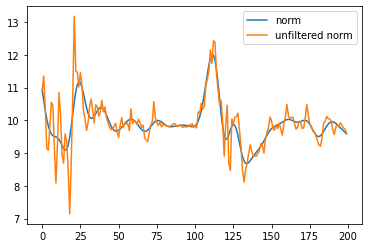

In [7]:
#plt.plot(x_data[0,:,0], label="0")
#plt.plot(x_data[0,:,1], label="1")
plt.plot((x_data[0,:,0]**2 + x_data[0,:,1]**2 + x_data[0,:,2]**2)**0.5, label="norm")
plt.plot(x_data[0,:,3], label="unfiltered norm")
plt.legend()
plt.show()

In [8]:
import datetime, csv, os, re, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold


#configs
maxprewindowsize = 4
classifier = 'rfc'

folds = 10


def get_average(l):
	return 0 if 0 == len(l) else sum(l) / len(l)

def get_eer(scores_legit, scores_adv):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			return threshold, far
	print("Failure")

def get_eer_recogblind(scores_legit, scores_adv_typed, total_w, total_b, total_i):
	scores_legit = sorted(scores_legit)
	scores_adv_typed = sorted(scores_adv_typed, key = lambda x:x[0])
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv_typed) if x[1][0] > threshold), len(scores_adv_typed))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			rejectrate_w = 0 if 0 == total_w else len([i for i in scores_adv_typed if 'W' == i[1] and i[0] >= threshold]) / total_w
			rejectrate_b = 0 if 0 == total_b else len([i for i in scores_adv_typed if 'B' == i[1] and i[0] >= threshold]) / total_b
			rejectrate_i = 0 if 0 == total_i else len([i for i in scores_adv_typed if 'I' == i[1] and i[0] >= threshold]) / total_i
			return threshold, far, rejectrate_w, rejectrate_b, rejectrate_i

def get_far_when_zero_frr(scores_legit, scores_adv):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr > 0.001:
			return threshold, far

def plot_threshold_by_far_frr(scores_legit, scores_adv, far_theta):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	frr = []
	far = []
	thresholds = []
	for c, threshold in enumerate(scores_legit):
		frr.append((c * 1.0 / len(scores_legit)) * 100)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far.append((1 - (adv_index * 1.0 / len(scores_adv))) * 100)
		thresholds.append(threshold)
	plt.figure(figsize = (6, 6))
	plt.rcParams.update({'font.size': fontsize_legends})
	plt.plot(thresholds, far, 'tab:blue', label = 'FAR')
	plt.plot(thresholds, frr, 'tab:orange', label = 'FRR')
	plt.ylabel('error rate (%)')
	plt.xlabel(r'decision threshold, $\theta$')
	plt.axvline(x = far_theta, c = 'red')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def plot_threshold_by_precision_recall(labels_test, labels_scores):
	p, r, thresholds = precision_recall_curve(labels_test, labels_scores)
	plt.figure(figsize = (6, 6))
	plt.rcParams.update({'font.size': fontsize_legends})
	plt.title('Precision and Recall Scores as a Function of the Decision Threshold', fontsize = 12)
	plt.plot(thresholds, p[:-1], 'tab:blue', label = 'precision')
	plt.plot(thresholds, r[:-1], 'tab:orange', label = 'recall')
	plt.ylabel('score')
	plt.xlabel(r'decision threshold, $\theta$')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def plot_roc_curve(labels_test, labels_scores):
	fpr, tpr, auc_thresholds = roc_curve(labels_test, labels_scores)
	print('AUC of ROC = ' + str(auc(fpr, tpr)))
	plt.figure(figsize = (6, 6))
	plt.rcParams.update({'font.size': fontsize_legends})
	plt.title('ROC Curve', fontsize = 12)
	plt.plot(fpr, tpr, 'tab:orange', label = 'recall optimized')
	plt.plot([0, 1], [0, 1], 'k--')
	plt.axis([-0.005, 1, 0, 1.005])
	plt.xticks(np.arange(0, 1, 0.05), rotation = 90)
	plt.xlabel('false positive rate')
	plt.ylabel('true positive rate (recall)')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def get_ascending_userID_list_string():
	for u in userIDs:
		if not 'user' in u and len(u) != 7:
			sys.exit('ERROR: userID not valid: ' + str(u))
	IDs = [int(u[4:]) for u in userIDs]
	IDs.sort(reverse = False)
	return ','.join([f'{i:03}' for i in IDs])

def get_descending_feature_list_string(weights, labels, truncate = 0):
	indicies = [i for i in range(len(weights))]
	for i in range(len(indicies)):
		for j in range(len(indicies)):
			if i != j and weights[indicies[i]] > weights[indicies[j]]:
				temp = indicies[i]
				indicies[i] = indicies[j]
				indicies[j] = temp
	if truncate != 0:
		del indicies[truncate:]
	return '\n'.join([str('%.6f' % weights[i]) + ' (' + labels[i] + ')' for i in indicies])

def write_verbose(f, s):
	outfilename = f + '-verbose.txt'
	outfile = open(outfilename, 'a')
	outfile.write(s + '\n')
	outfile.close()


    
output = []



#auth_user = 3


repetitions = 10

for auth_user in range(16):
    output.append({"fm":[], "prec":[], "rec":[], "eer":[], "far":[]})
    print(f"auth_user is {auth_user}")

    for percentile in range(0, 100, 20):
        
        
        a_precisions = []
        a_recalls = []
        a_fmeasures = []
        a_pr_stdev = []
        a_re_stdev = []
        a_fm_stdev = []
        a_eers = []
        a_eer_thetas = []
        a_fars = []
        a_far_thetas = []
        a_ee_stdev = []
        a_ee_th_stdev = []
        a_fa_stdev = []
        a_fa_th_stdev = []

        print(f"percentile is {percentile}")
        perc = (percentile) / 100




        auth_gesture_map = (y_intent == 1) & (y_user.argmax(axis=1) == auth_user)

        total_auth_gestures = sum(auth_gesture_map)

        # test mapping is the last third of gestures
        final_third = int(total_auth_gestures * (2/3))

        train_data_map = np.zeros(len(feature_array))
        test_data_map = np.zeros(len(feature_array))

        auth_indices_to_remove = []

        for user in range(16):
            user_train_data_map = ((y_intent == 1) & (y_user.argmax(axis=1) == user))
            total = sum(user_train_data_map)

            threshold = int(total * (2/3))

            count = 0
            ii = 0
            while count < threshold:

                if user_train_data_map[ii] == 1:
                    count += 1
                    if user == auth_user:    
                        auth_indices_to_remove.append(ii)
                ii += 1
            user_train_data_map[ii:] = 0

            train_data_map = (user_train_data_map + train_data_map)

        test_data_map = (y_intent == 1) * (1-train_data_map)
        


        auth_indices_to_remove = np.array(auth_indices_to_remove)
        indices_to_remove = np.random.choice(auth_indices_to_remove, replace=False,
                               size=int(len(auth_indices_to_remove) * perc))


        to_remove = np.ones(len(train_data_map))
        to_remove[indices_to_remove] = 0

        train_data_map = train_data_map * (to_remove)


        train_data_map = train_data_map.astype(bool)
        test_data_map = test_data_map.astype(bool)

        #############

        data_train = feature_array[train_data_map]

        labels_train = (y_user.argmax(axis=1) == auth_user)[train_data_map].astype(int)
        
        data_test = feature_array[test_data_map]
        labels_test = (y_user.argmax(axis=1) == auth_user)[test_data_map].astype(int)

        

        for repetition in range(repetitions):
            model = RandomForestClassifier(n_estimators = 100, random_state = repetition).fit(data_train, labels_train)
            #, class_weight="balanced"
            

            labels_pred = model.predict(data_test)


            #get precision, recall, and F-measure scores
            precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
            recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
            fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred)) # macro vs binary
            a_precisions.append(precision)
            a_recalls.append(recall)
            a_fmeasures.append(fmeasure)

            #print(precision)
            #print(recall)

            #get EER and find the decision threshold and FAR when optimised for FRR
            labels_scores = model.predict_proba(data_test)[:, 1]
            scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
            scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]
            eer_theta, eer = get_eer(scores_legit, scores_adv)
            #print(f"eer is {eer}")
            a_eers.append(eer)
            a_eer_thetas.append(eer_theta)
            far_theta, far = get_far_when_zero_frr(scores_legit, scores_adv)
            a_fars.append(far)
            a_far_thetas.append(far_theta)


        a_pr_stdev = np.std(a_precisions, ddof = 1)
        a_re_stdev = np.std(a_recalls, ddof = 1)
        a_fm_stdev = np.std(a_fmeasures, ddof = 1)
        a_ee_stdev = np.std(a_eers, ddof = 1)
        a_ee_th_stdev = np.std(a_eer_thetas, ddof = 1)
        a_fa_stdev = np.std(a_fars, ddof = 1)
        a_fa_th_stdev = np.std(a_far_thetas, ddof = 1)

        output[auth_user]["fm"].append(get_average(a_fmeasures))
        output[auth_user]["prec"].append(get_average(a_precisions))
        output[auth_user]["rec"].append(get_average(a_recalls))
        output[auth_user]["eer"].append(get_average(a_eers))
        output[auth_user]["far"].append(get_average(a_fars))

    for stat in output[auth_user]:
        fig = plt.figure(facecolor=(1, 1, 1))
        ax = fig.add_axes([0,0,1,1])
        ax.set_title(f"{auth_user}_{stat}")
        ax.set_xlabel("% auth data in use")
        ax.plot(100 - np.array(range(0,100, 20)), np.array(output[auth_user][stat]))
        fig.savefig(f"images/{auth_user}_{stat}_replication_against_percentage_data.jpg", bbox_inches='tight', dpi=150)
        #plt.show()
        plt.clf()

    import pickle

    with open('watch_auth_stats_partial_data_replication.pickle', 'wb') as handle:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

auth_user is 0
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 1
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 2
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 3
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 4
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80


/tmp/ipykernel_114/1891983039.py:283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor=(1, 1, 1))


auth_user is 5
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 6
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 7
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 8
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 9
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 10
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 11
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 12
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 13
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_user is 14
percentile is 0
percentile is 20
percentile is 40
percentile is 60
percentile is 80
auth_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
for user in range(16):
    print(sum((y_intent == 1) & (y_user.argmax(axis=1) == user)))

209
206
261
194
923
225
206
223
139
136
219
271
231
254
244
254


In [23]:
precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))


print(precision)
print(recall)
print(fmeasure)

print(np.unique(labels_test,return_counts=True))
print(np.unique(labels_pred,return_counts=True))

NameError: name 'labels_pred' is not defined

## VAE with multiple outputs from latent space

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, _classifier = None, _auth = None, beta = 0.001, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.classifier = _classifier
        self.auth = _auth
        #self.classifier = keras.models.load_model(f'data/models/{model_name}.hdf5')

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.feature_loss_tracker = keras.metrics.Mean(
            name="feature_loss"
        )
        self.classification_loss_tracker = keras.metrics.Mean(
            name="classification_loss"
        )
        self.reencoding_loss_tracker = keras.metrics.Mean(
            name="reencoding_loss"
        )
        self.auth_loss_tracker = keras.metrics.Mean(name="auth_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta = beta

    def save_model(self, folder, tag):
        
        with open(f'data/models/{folder}/enc_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.encoder, f)

        with open(f'data/models/{folder}/dec_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.decoder, f)

        with open(f'data/models/{folder}/auth_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.auth, f)
    
    def load_model(self, folder, tag):
        
        with tf.keras.utils.custom_object_scope({'Sampling': Sampling}):
            with open(f'data/models/{folder}/enc_{tag}.pickle', 'rb') as pickle_file:
                self.encoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/dec_{tag}.pickle', 'rb') as pickle_file:
                self.decoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/auth_{tag}.pickle', 'rb') as pickle_file:
                self.auth = pickle.load(pickle_file)
        
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.feature_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data, y_user_one_hot = data
        print(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            #data_probability = self.classifier(data)
            #reconstruction_probability = self.classifier(reconstruction)
            #classification_loss = tf.reduce_mean(abs(data_probability - reconstruction_probability))

            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction), axis=1) # * data_probability
            
            #re_encoded, _, _ = self.encoder(reconstruction)
            #reencoding_loss = tf.reduce_mean(keras.losses.mse(z_mean, re_encoded))
            
            #feature_loss = tf.reduce_mean(keras.losses.MeanAbsolutePercentageError(self.batch_features(data), self.batch_features(reconstruction)))
            
            feature_loss = 0.5 * (tf.reduce_mean(keras.losses.mse(self.rolling_max(data), self.rolling_max(reconstruction))) + 
                                          tf.reduce_mean(keras.losses.mse(self.rolling_min(data), self.rolling_min(reconstruction))) )

            #reconstruction_loss = tf.reduce_mean(keras.losses.mean_absolute_error(data, reconstruction), axis=1)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            auth_output = self.auth(z)
            
            auth_loss = tfr.keras.losses.ApproxMRRLoss()(y_user_one_hot, auth_output) ## TODO - figure out how to get true values in here

            sample_loss = 0.5 * reconstruction_loss + 0.5 * feature_loss #+ 0.0 * feature_loss
            
            total_loss = auth_loss + sample_loss + self.beta * kl_loss #+ classification_loss # + 0.1*feature_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.auth_loss_tracker.update_state(auth_loss)
        #self.feature_loss_tracker.update_state(feature_loss)
        #self.reencoding_loss_tracker.update_state(reencoding_loss)
        #self.classification_loss_tracker.update_state(classification_loss) #
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "feature_loss"       : self.feature_loss_tracker.result(),
            "auth_loss": self.auth_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def batch_features(self, x):
        feature_list = []
        #_max = tf.math.reduce_max(x, axis=1)
        #_min = tf.math.reduce_min(x, axis=1)
        _segment_max = self.rolling_max(x)
        _segment_min = self.rolling_min(x)
        _range = _segment_max - _segment_min
        
        _mean = tf.math.reduce_mean(_range, axis=0)
        _std = tf.math.reduce_std(_range, axis=0)
        
        return [ _mean, _std] # _max, _min,


    def rolling_max(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
    
    def rolling_min(self, x):
        return -tf.nn.pool(
            -x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
        
    def rolling_mean(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MEAN",
            strides=(5,),
            padding='VALID'
        )
        

In [14]:
auth_user = 15
auth_map = (y_intent == 1) & (y_user.argmax(axis=1) != auth_user)


weighted_auth_data = np.concatenate([unweighted_data[y_user.argmax(axis=1) != auth_user]] + [unweighted_data[auth_map] for i in range(20)])
weighted_y_auth_data = np.concatenate([y_user[y_user.argmax(axis=1) != auth_user]] + [y_user[auth_map] for i in range(20)])

vae = VAE(None, None, None)
vae.load_model("no_15", "all_data")

opt = keras.optimizers.Adam()



NameError: name 'unweighted_data' is not defined